# Important [Clicking here for the nbviewer version](https://nbviewer.jupyter.org/github/cescnghia/ADA2017/blob/master/03%20-%20Interactive%20Viz/Homework%203.ipynb)

In [5]:
import os
import pandas as pd
import json
import folium
import numpy as np
import matplotlib.pyplot as plt
import branca.colormap as cm
from IPython.display import Image
%matplotlib inline

In [6]:
"""EUROPE DATA FROM 'http://appsso.eurostat.ec.europa.eu/nui/submitViewTableAction.do"""

eu_data_path = 'data/chomage_europe.csv'
swiss_data_path = 'data/chomage_suisse.csv'
swiss_foreign_path = 'data/chomage_suisse_etrangere.csv'
swiss_ages_path = 'data/chomage_suisse_age.csv'
swiss_combine_path =  'data/combine_suisse.csv'

eu_topo_path = 'topojson/europe.topojson.json'
swiss_topo_path = 'topojson/ch-cantons.topojson.json'

eu_topo_data = json.load(open(eu_topo_path))
swiss_topo_data = json.load(open(swiss_topo_path))

# Question 1

The data that we collected doesn't have all rates of all countries from europe. But at least it contains Switzerland's rate in order to be able to compare. You can click on the link above if you are curious!. Since we also have to find a way to show these countries are not present in the data on the map, we decided to assign value 0 to their rate.

In [7]:
def parse_eu_data(eu_data_path):
    df = pd.read_csv(eu_data_path)
    df = df[(df.ISCED11 == "All ISCED 2011 levels ") & (df.SEX == 'Total')]
    """Insert ID column using data from europe.topojson.json"""
    """For those countries that we don't have data (umployment rates), we put 0 for the rate"""
    names = df.GEO.tolist()
    countries = eu_topo_data['objects']['europe']['geometries']
    ids = []
    ids_no_data = []
    rates = []
    c = []
    c_no_data = []
    for country in countries:
        name = country['properties']['NAME']

        if name in names:
            c.append(name)
            ids.append(country['id'])
            rates.append(df.loc[df['GEO'] == name]['Value'].values[0])
        else:
            c_no_data.append(name)
            ids_no_data.append(country['id'])
    """Order is important because we take Rate and concatenate"""
    ids += ids_no_data         
    rates += [0]*(len(ids_no_data))
    c += c_no_data
    df = pd.DataFrame({
                        'Code' : ids,
                        'Rate' : rates,
                        'Country' : c
                     }) 
    df.Rate = df.Rate.astype(float)
    return df

In [8]:
df_eu = parse_eu_data(eu_data_path)
df_eu

,Code,Country,Rate
0,BG,Bulgaria,7.6
1,CY,Cyprus,13.0
2,DK,Denmark,6.2
3,IE,Ireland,7.9
4,EE,Estonia,6.8
5,AT,Austria,6.0
6,CZ,Czech Republic,4.0
7,FI,Finland,8.8
8,FR,France,10.1
9,DE,Germany,4.1


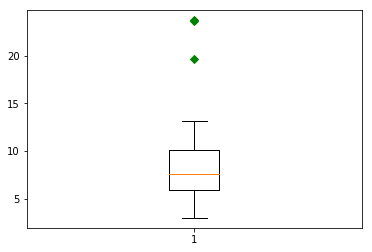

In [9]:
plt.boxplot(df_eu[df_eu.Rate > 0].Rate, 0, 'gD')
plt.show()

#### One word about the choice of color for this assignment:

We chose *YlOrRd* (which is a sequential mapping color from yellow to red) because in almost all of cases, red means WARNING. Link to our homework, unemployment rate is a big problem of a country. So we decided to map red color to those countries/cantons that have a high unemployment rate

First, we decide to map gray color to those countries that we don't have data. Then as we saw here, there were two countries in which unemployement rate is an extreme case (nearly outliers), so we put these two countries into a special class... After, since we have to classifier for more than 30 countries, we decide to split these countries into 5 classes... In total, on our map we have 6 class:
* Countries that we do not know their rate
* Countries that unemployment rate is smaller than the first quartile
* Countries that unemployment rate is bigger than the first quartile but smaller than the median (second quartile)
* Countries that unemployment rate is bigger than the median but smaller than the third quartile
* Countries that unemployment rate is bigger than the third quartile but smaller than 15%
* Countries that unemployment rate is bigger than the 15%

In [10]:
[first_quartile, median, third_quartile] = np.percentile(df_eu[df_eu.Rate > 0].Rate, [25, 50, 75])
thresholds_eu = [min(df_eu[df_eu.Rate > 0].Rate), first_quartile , median, third_quartile, 15, max(df_eu.Rate)]
"5-class YlOrRd"
colors_mapping = ['#ffffb2', '#fecc5c','#fd8d3c', '#f03b20', '#bd0026'] 

colormap_eu = cm.StepColormap(colors_mapping, 
                              vmin=min(df_eu[df_eu.Rate > 0].Rate), vmax=max(df_eu.Rate), 
                              index=thresholds_eu,
                              caption='Unemployment rates of Europe in 2016 (No data found for those countries in gray )')
colormap_eu

In [11]:
def eu_style_func(code):
    rate = df_eu.loc[df_eu['Code'] == code]['Rate'].values[0]
    if (rate == 0) : 
        return 'gray'
    else : 
        return colormap_eu(rate)

In [12]:
eu_map = folium.Map(location=[40,10], zoom_start=3, tiles='cartodbpositron')
folium.TopoJson(
    eu_topo_data,
    'objects.europe',
    style_function=lambda feature: {
        'fillColor' : eu_style_func(feature['id']),
        'color' : 'black',
        'weight' : 1,
        'fillOpacity' : 1,
        'dashArray' : '1, 1'
        }
    ).add_to(eu_map)
eu_map.add_child(colormap_eu)
eu_map.save('eu_map.html')
eu_map

#### Observations:
* Switzerland is in the first zone (lowest rate) among europe, which means the economy of Switzerland is stable and the jobs don't scarce.
* Countries in the Southern Europe have the highest unemployment rate among europe (because of the immigration ? or because they don't have enough jobs for their citizen ? or beacause the countries in Western and Northern Europe are richer ?)
* Czech Republic, Iceland, UK, Switzerland, Germany, Norway, Malta are stable while Spain, Macedonia and Greece are in the danger zone. Portugal, Italy, Cyprus, Croatia, France, Turkey have to be careful about their unemployment rate.

# Question 2

We collected data from Switzerland at September 2017 (at a recent date). Moreover, the fact of data collected in 2016 or September 2017 is not important for a Visualization project. The important things are how to define threshold and color mapping on the map.

In [13]:
df_suisse_stat = pd.read_csv(swiss_data_path, usecols=[0,1,2,3,4])
df_suisse_stat

,Canton,Taux de chomage,Chomeurs inscrits,Demandeurs demploi,Demandeurs demploi non chomeurs
0,ZH,3.3,27225,34156,6931
1,BE,2.4,13658,18385,4727
2,LU,1.7,3885,6756,2871
3,UR,0.6,112,257,145
4,SZ,1.7,1455,2229,774
5,OW,0.7,153,319,166
6,NW,1.0,248,436,188
7,GL,1.8,416,713,297
8,ZG,2.3,1543,2615,1072
9,FR,2.7,4466,7837,3371


Now, let's say the unemployment rate defined by Swiss Confederation is RATE_A vs RATE_B (the
unemployment rate in which we don't count in your statistics people who already have a job and are looking for a new one) => RATE_B is defined by the quotient of 'chomage_inscrits' and 'demandeurs demploi' then time with the 'taux de chomage'

In [14]:
RATE_A = df_suisse_stat['Taux de chomage']
RATE_B = np.round(df_suisse_stat['Chomeurs inscrits'] / df_suisse_stat['Demandeurs demploi'] * df_suisse_stat['Taux de chomage'], 1)

In [15]:
df_suisse = pd.DataFrame({
    'CODE' : df_suisse_stat['Canton'],
    'RATE_A' : RATE_A,
    'RATE_B' : RATE_B
})
df_suisse

,CODE,RATE_A,RATE_B
0,ZH,3.3,2.6
1,BE,2.4,1.8
2,LU,1.7,1.0
3,UR,0.6,0.3
4,SZ,1.7,1.1
5,OW,0.7,0.3
6,NW,1.0,0.6
7,GL,1.8,1.1
8,ZG,2.3,1.4
9,FR,2.7,1.5


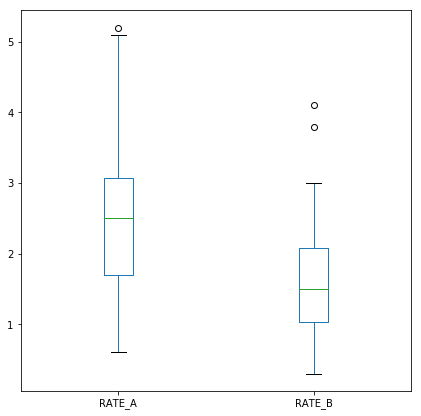

In [16]:
df_suisse.plot(kind='box', figsize=(7,7))

Switzerland :
* RATE_A : the mean is about 2.5% and the max rate is about 5.2% which is quite near the limit horizontal bar. The difference is not high so we have decided to divide the threshold into 4 classes by the quartile method.
* RATE_B : There is a huge change (about 1%) in average rate. For the purpose of comparison, we use the same threshold defined for RATE_A.

### RATE_A: rate defined by Swiss Confederation

In [17]:
print('Unemployment mean of RATE_A:',np.mean(df_suisse.RATE_A))

Unemployment mean of RATE_A: 2.5230769230769234


In [18]:
colors_A = ['#ffffb2','#fecc5c','#fd8d3c','#e31a1c']

[first_quartile_A, median_A, third_quartile_A] = np.percentile(df_suisse.RATE_A, [25, 50, 75])
thresholds_suisse_A = [min(df_suisse.RATE_A), first_quartile_A, median_A, third_quartile_A, max(df_suisse.RATE_A)]

colormap_suisse_A = cm.StepColormap(colors_A, 
                                  vmin = min(df_suisse.RATE_A), vmax = max(df_suisse.RATE_A), 
                                  index = thresholds_suisse_A,
                                  caption='Unemployment rates in Switzerland in September 2017')
colormap_suisse_A

In [19]:
suisse_map_A = folium.Map(location=[46.9,8], zoom_start=8, tiles='cartodbpositron')
folium.TopoJson(
    swiss_topo_data,
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_suisse_A(df_suisse.loc[df_suisse['CODE'] == feature['id']]['RATE_A'].values[0]),
        'color' : 'black',
        'fillOpacity' : 1,
        'weight' : 1,
        'dashArray' : '1, 1'
        }
    ).add_to(suisse_map_A)
suisse_map_A.add_child(colormap_suisse_A)
suisse_map_A.save('suisse_map_A.html')
suisse_map_A

#### Observations:
* Cantons that have a big city/hub (Geneva, Lausanne, Zurich, Ticino..) tend to have higher unemployment rate. Are there a lot of concurrences for finding a job in these cities ?
* Switzerland has two *Swiss Federal Institute of Technology* in Lausanne and Zurich. Therefore, there are a lot of jobs, start-ups, companies are based not only in these two cities but also in some cities nearby (Neuchatel, Geneva...). And it leads to the concurrences for finding a job => higher unemployment rate.
* We can see that cantons in center Switzerland and some cantons from the east part have lower unemployment rate than the others. Considering the density map of Switzerland (below),we can see that there are some correlations between them, because population desity in this region is not high...
* Also, when people immigrate to Switzerland, they usualy choose a big city/hub to join...

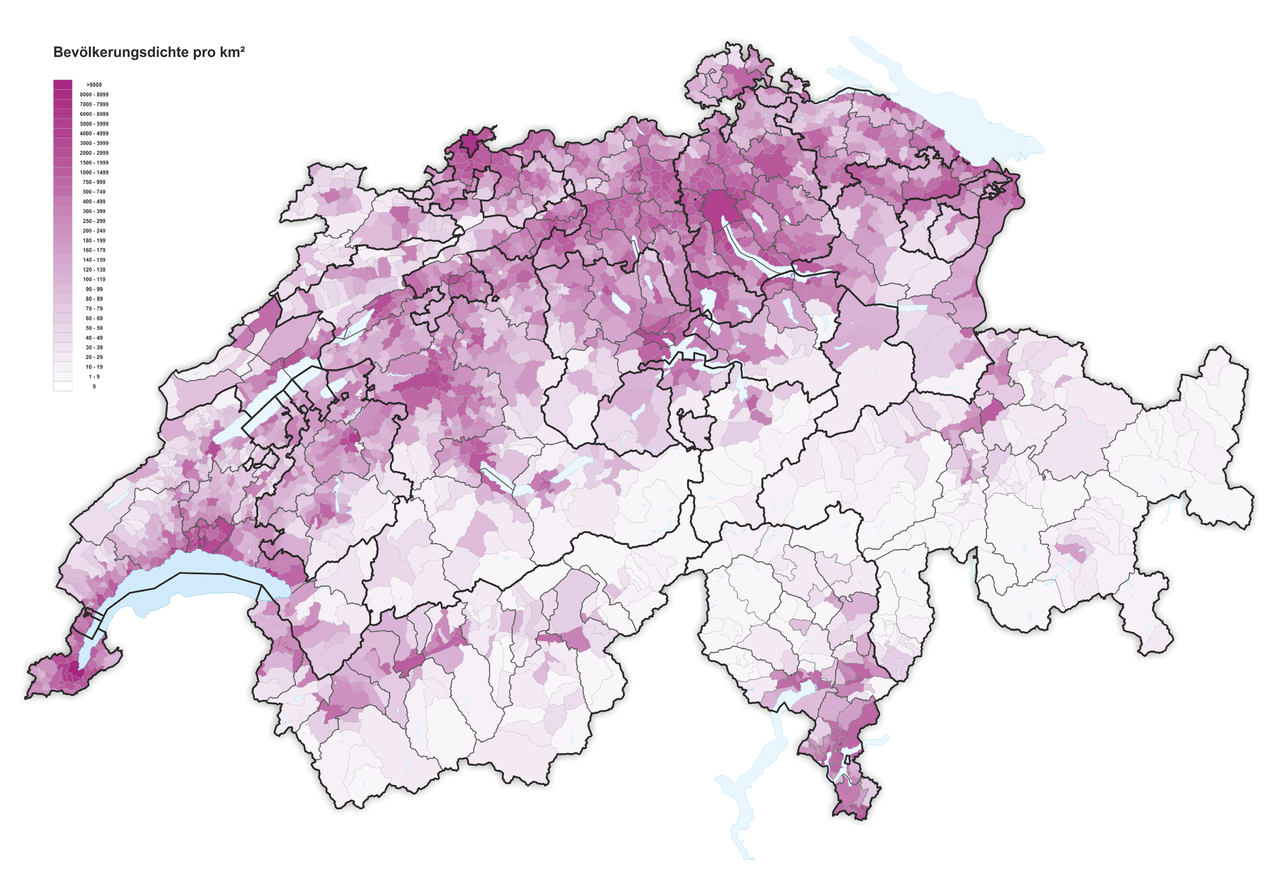

In [20]:
"""Population density of Switzerland"""

Image('Suisse-densite-2016.png')

## RATE_B: don't count people who already have a job and are looking for a new one

In [21]:
print('Unemployment mean of RATE_B:',np.mean(df_suisse.RATE_B))

Unemployment mean of RATE_B: 1.6576923076923078


In [22]:
suisse_map_B = folium.Map(location=[46.9,8], zoom_start=8, tiles='cartodbpositron')
folium.TopoJson(
    swiss_topo_data,
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_suisse_A(df_suisse.loc[df_suisse['CODE'] == feature['id']]['RATE_B'].values[0]),
        'color' : 'black',
        'fillOpacity' : 1,
        'weight' : 1,
        'dashArray' : '1, 1'
        }
    ).add_to(suisse_map_B)
suisse_map_B.save('suisse_map_B.html')
suisse_map_B

With the new rate (B), we can see that unemployment rate for people that DON'T HAVE a job is much lower than the one defined in A. Using the same threshold defined for RATE_A we saw a big difference compared to the one of RATE_A. The rate in average is much lower (1.65 vs 2.52)

# Question 3

### Difference between Swiss rate and Foreign rate

In [23]:
df = pd.read_csv(swiss_foreign_path, usecols=[0,1,2])
df_Swiss   = df[df['Nationalite']=='Suisses']
df_Foreign = df[df['Nationalite']=='Etrangers']

In [24]:
df = pd.DataFrame({
    'CODE' : [c for c in df_Swiss.CODE],
    'SWISS_RATE' : [r for r in df_Swiss.RATE],
    'FOREIGN_RATE' : [r for r in df_Foreign.RATE]
})
df['RATIO'] = np.round(df.FOREIGN_RATE / df.SWISS_RATE, 1)
df

,CODE,FOREIGN_RATE,SWISS_RATE,RATIO
0,ZH,5.3,2.5,2.1
1,BE,5.5,1.8,3.1
2,LU,3.9,1.3,3.0
3,UR,2.1,0.4,5.2
4,SZ,3.4,1.2,2.8
5,OW,2.2,0.5,4.4
6,NW,2.9,0.7,4.1
7,GL,3.4,1.4,2.4
8,ZG,3.9,1.7,2.3
9,FR,5.0,2.0,2.5


In [25]:
print('Unemployment rate in Switzerland of Swiss', np.mean(df.SWISS_RATE))
print('Unemployment rate in Switzerland of Foreigners', np.mean(df.FOREIGN_RATE))

Unemployment rate in Switzerland of Swiss 1.9576923076923076
Unemployment rate in Switzerland of Foreigners 4.4653846153846155


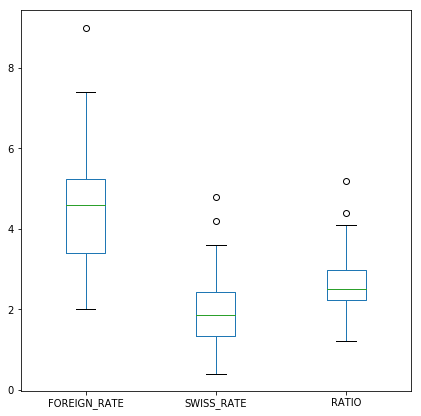

In [26]:
df.plot(figsize=(7,7), kind='box')

Since the ratio is kind of special: ratio = 1 means the foreign rate equals to the swiss rate while ratio = 2 means the foreign rate is 2 times higher than the swiss rate ... This time, instead of using the quartile method we would like to divide the threshold in the following intervals: [min,2], [2,3], [3,4], [4, max]

In [27]:
thresholds_suisse_C = [min(df.RATIO), 2.1, 3, 4, max(df.RATIO)]
colors_C = ['#ffffb2','#fecc5c','#fd8d3c','#e31a1c']
colormap_suisse_C = cm.StepColormap(colors_C, 
                                  vmin = min(df.RATIO), vmax = max(df.RATIO), 
                                  index = thresholds_suisse_C,
                                  caption='Ratio of unemployment rates of Foreign vs Swiss in Switzerland 09/2017')
colormap_suisse_C

In [28]:
suisse_map_C = folium.Map(location=[46.9,8], zoom_start=8, tiles='cartodbpositron')
folium.TopoJson(
    swiss_topo_data,
    'objects.cantons',
    style_function=lambda feature: {
        'fillColor': colormap_suisse_C(df.loc[df['CODE'] == feature['id']]['RATIO'].values[0]),
        'color' : 'black',
        'fillOpacity' : 1,
        'weight' : 1,
        'dashArray' : '1, 1'
        }
    ).add_to(suisse_map_C)
suisse_map_C.add_child(colormap_suisse_C)
suisse_map_C.save('suisse_map_C.html')
suisse_map_C

[Percentage of foreigner per canton in Switzerland](https://www.travailler-en-suisse.ch/classement-cantons-suisses-immigration-etrangers-16-06-2011.html)

* First of all, we saw that the darkness of the color has a correlation with the percentage of foreigners in Switzerland. Precisely, the percentage of foreigners of cantons in red is small (UR - 9.5%, OW - 13.3%, NW - 11.3%) vs the one of cantons in yellow is big (GE - 36%, VD - 31%, TI - 26%)

* Do foreign workers take the jobs from swiss people and this leads to the reduction of the ratio of unemployment rates between foreign and swiss?

* Secondly, we also saw that the darkness of the color has somehow a correlation with the population. Precisely, the population in these cantons (Red: UR, OW, NW. Orange: GR, AI) is very small while population in VD, GE, TI (yellow) is bigger.

* Another hypothesis that can also be made is: is it more difficult for foreigners, living in less populated cantons, to find a job? And it leads to the fact that foreigners have to move to big cities/hubs(VD, GE, ZH) ???

* It seems that most of the cantons in Switzerland have a ratio between [2,3] which means that the ratio of the unemployment rate of foreigners is about 2 or 3 times higher than the one of swiss citizenship. 

### Differences between age groups

In [29]:
df_age = pd.read_csv(swiss_ages_path, usecols=[0,2,3])
df_age_one   = df_age[df_age['Mesures']=='15-24 ans']
df_age_two   = df_age[df_age['Mesures']=='25-49 ans']
df_age_three = df_age[df_age['Mesures']=='50 ans et plus']

df_age_one.head()

,Canton,Mesures,Taux de chomage
0,Zurich,15-24 ans,3.7
3,Berne,15-24 ans,2.8
6,Lucerne,15-24 ans,2.1
9,Uri,15-24 ans,0.5
12,Schwyz,15-24 ans,1.6


In [30]:
df = pd.DataFrame({
    'Canton' : [c for c in df_age_one.Canton],
    '15-24 years old' : [r for r in df_age_one['Taux de chomage']],
    '25-49 years old' : [r for r in df_age_two['Taux de chomage']],
    '50 years old and more' : [r for r in df_age_three['Taux de chomage']],
})
df = df.set_index('Canton')

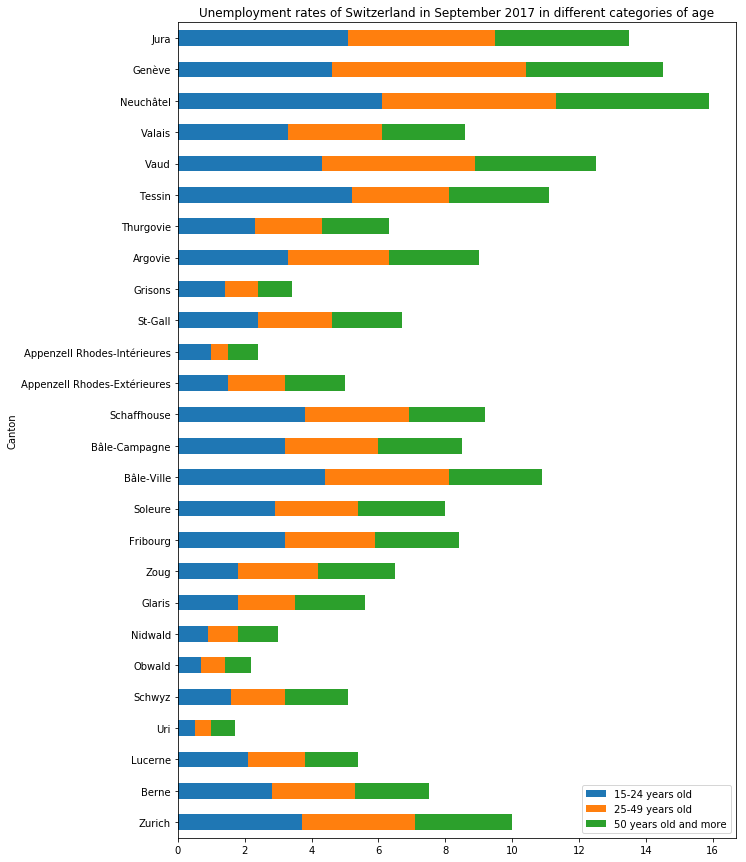

In [31]:
df.plot.barh(stacked=True, figsize=(10,15), title='Unemployment rates of Switzerland in September 2017 in different categories of age')

### Combine differences between age groups and nationality

In [32]:
swiss_combine = pd.read_csv(swiss_combine_path, usecols=[0,1,3,4])
swiss_combine.head(10)

,Canton,Nationalite,Mesures,Demandeurs demploi
0,ZH,Etrangers,15-24 ans,1178
1,ZH,Etrangers,25-49 ans,11188
2,ZH,Etrangers,50 ans et plus,3018
3,ZH,Etrangers,NaN,15384
4,ZH,Suisses,15-24 ans,2671
5,ZH,Suisses,25-49 ans,10083
6,ZH,Suisses,50 ans et plus,6018
7,ZH,Suisses,NaN,18772
8,ZH,Total,NaN,34156
9,BE,Etrangers,15-24 ans,722


In [33]:
swiss_rate = swiss_combine[swiss_combine['Nationalite']=='Suisses']
swiss_rate = swiss_rate.groupby(['Mesures'])[["Demandeurs demploi"]].sum()
swiss_rate.columns = ['Swiss']
swiss_rate = swiss_rate.reset_index()
swiss_rate

,Mesures,Swiss
0,15-24 ans,15144
1,25-49 ans,55326
2,50 ans et plus,34609


In [34]:
foreign_rate = swiss_combine[swiss_combine['Nationalite']=='Etrangers']
foreign_rate = foreign_rate.groupby(['Mesures'])[["Demandeurs demploi"]].sum()
foreign_rate.columns = ['Foreigners']
foreign_rate = foreign_rate.reset_index()
foreign_rate

,Mesures,Foreigners
0,15-24 ans,8026
1,25-49 ans,61052
2,50 ans et plus,19467


In [35]:
merge_rate = swiss_rate.merge(foreign_rate,on='Mesures')
merge_rate = merge_rate.set_index('Mesures')
merge_rate

,Swiss,Foreigners
Mesures,,
15-24 ans,15144,8026
25-49 ans,55326,61052
50 ans et plus,34609,19467


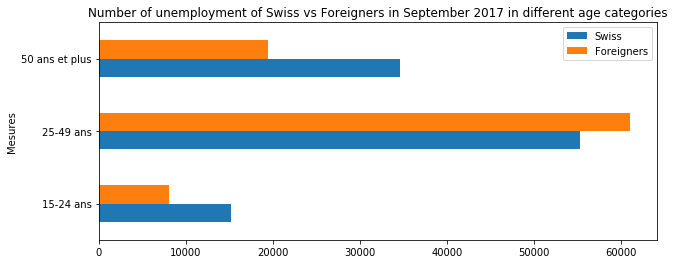

In [36]:
merge_rate.plot.barh(figsize=(10,4), 
                     title='Number of unemployment of Swiss vs Foreigners in September 2017 in different age categories')

Why is the number of unemployment of foreigners bigger than number of unemployment of swiss for the age group 25-49 ?

The reason for this may be because most of the people who migrate to Switzerland are in this age group and there are higher chances that they don't speak the official language and have lower education, so it is harder to find a job.

## Röstigraben

In [37]:
suisse_map_A

Unemployment rate can be mapped into a scale of warning:
* French-speaking : High
* Italian-speaking: High
* German-speaking : Considerable/Moderate
* Romash-speaking : Low

In [38]:
rate = r'data/language.xlsx'
rate = pd.read_excel(rate, header=[1], skip_footer=1, index_col=None)
rate

,Mesures,Taux de chômage,Taux de chômage.1
Suisse alémanique,NaN,2.6,2.6
Suisse romande et Tessin,NaN,4.0,4.0


From this we can conclude that the unemployement rate is higher in the french part. The reason for this may be the number of foreigners. Also as we can see on the map the unemployement is higher in the border cantons with France, because of the border workers. So to some extend the Röstigraben does exist.